In [1]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import time
import numpy as np
import matplotlib.pyplot as plt
from mnist_model import Net

## Variables

In [2]:
PATIENCE = 20
PATH = 'trained_models\\'
FIG_PATH = 'illustrations_and_results\\'
MNIST_CNN_PATH = 'trained_models\mnist_cnn_epoch62.pt'
PIC_DIM = 28
EPS = 0.25
C = 1
GAMMA = 0.0
THR = 0.0

## Basic model and loss function

In [3]:
def custom_loss(output, noise, target, cnn):
    preds = cnn(output)
    loss = C / F.nll_loss(preds, target) + GAMMA * torch.sum(torch.abs(noise)) / len(noise)
    return loss


class PGEN_NN(nn.Module):
    def __init__(self):
        super(PGEN_NN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(2704, 1024)
        self.fc2 = nn.Linear(1024, 784)

    def forward(self, x):
        org = x
        x = self.conv1(x)  # 16,26,26
        x = F.relu(x)
        x = F.max_pool2d(x, 2)  # 16,13,13
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = torch.reshape(x, (-1, 1, PIC_DIM, PIC_DIM))
        output = torch.clamp(torch.tanh(x) * EPS + org, 0, 1)
        return output, x

    def generate(self, x, device):
        org = x
        x = self.conv1(x)  # 16,26,26
        x = F.relu(x)
        x = F.max_pool2d(x, 2)  # 16,13,13
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = torch.reshape(x, (-1, 1, PIC_DIM, PIC_DIM))
        x = torch.tanh(x).cpu().numpy()
        x = torch.from_numpy(np.where(np.abs(x) > THR, x, 0)).to(device)
        output = torch.clamp(torch.sign(x) * EPS + org, 0, 1)
        return output, x

## Train and evaluation functions

In [4]:
def train(args, model, device, train_loader, optimizer, epoch, cnn):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output, noise = model(data)
        loss = custom_loss(output, noise, target, cnn)  # F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader, cnn):
    model.eval()
    test_loss = 0
    noise_count = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, noise = model.generate(data, device)
            noise_count += torch.sum(torch.abs(noise))
            test_loss += custom_loss(output, noise, target,
                                     cnn) * len(data)
            output = cnn(output)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTesting set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), noise average = {:.4f}\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset),
        noise_count / len(test_loader.dataset)))

    return test_loss, 100. * correct / len(test_loader.dataset)

## Runner function

In [5]:
def main(args, model, optimizer, cnn, train_loader, dev_loader, device):
    
    dev_losses = []
    train_losses = []
    dev_accuracy = []
    train_accuracy = []

    if not args['load_model']:  # don't need to load
        best_epoch = 0
        best_loss = float('inf')
        start_time = time.time()
        # run training
        for epoch in range(1, args['epochs'] + 1):
            train(args, model, device, train_loader, optimizer, epoch, cnn)
            
            print('Testing train set:')
            train_loss, train_acc = test(model, device, train_loader, cnn)
            print('Testing dev set:')
            dev_loss, dev_acc = test(model, device, dev_loader, cnn)
            dev_losses.append(dev_loss)
            dev_accuracy.append(dev_acc)
            train_losses.append(train_loss)
            train_accuracy.append(train_acc)
            
            if dev_loss < best_loss:  # found better epoch
                best_loss = dev_loss
                best_epoch = epoch
            if args['save_model']:  # need to save model
                model_name = args['model_name'] + '_epoch%d.pt' % epoch
                torch.save(model.state_dict(), PATH + model_name)

            """
            # add this section if want to use patience 
            if best_epoch + PATIENCE <= epoch:  # no improvement in the last PATIENCE epochs
                print('No improvement was done in the last %d epochs, breaking...' % PATIENCE)
                break
            """

        end_time = time.time()
        print('Training took %.3f seconds' % (end_time - start_time))
        print('Best model was achieved on epoch %d' % best_epoch)
        model_name =  args['model_name'] + '_epoch%d.pt' % best_epoch
        model.load_state_dict(torch.load(PATH + model_name))  # load model from best epoch
    else:  # need to load
        model.load_state_dict(torch.load(PATH + args['load_path']))
    
    return dev_losses, train_losses, dev_accuracy, train_accuracy

## Settings and hyperparameters initialization

In [6]:
args={}
# Training settings
args['batch_size'] = 64
args['test_batch_size'] = 1000
args['epochs'] = 70
args['no_cuda'] = False
args['seed'] = 1
args['log_interval'] = 100
args['save_model'] = True
args['load_model'] = False
args['load_path'] = ""
 
use_cuda = not args['no_cuda'] and torch.cuda.is_available()

torch.manual_seed(args['seed'])

device = torch.device("cuda" if use_cuda else "cpu")  # device to run the model on

# organize parsed data
train_kwargs = {'batch_size': args['batch_size']}
test_kwargs = {'batch_size': args['test_batch_size']}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                    'pin_memory': True,
                    'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

# get datasets and create loaders
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset1 = datasets.MNIST('../data', train=True, download=True,
                            transform=transform)
train_set, dev_set = torch.utils.data.random_split(dataset1, [50_000, 10_000],
                                                    generator=torch.Generator().manual_seed(42))
dataset2 = datasets.MNIST('../data', train=False, download=True,
                            transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, **train_kwargs)
dev_loader = torch.utils.data.DataLoader(dev_set, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

cnn = Net().to(device)
cnn.load_state_dict(torch.load(MNIST_CNN_PATH))
for param in cnn.parameters():
    param.requires_grad = False
_ = cnn.eval()


## Run model

In [7]:
# create model, initialize optimizer
args['model_name'] = 'pgen_nn'
model = PGEN_NN().to(device)
optimizer = optim.Adadelta(model.parameters())

dev_losses, train_losses, dev_accuracy, train_accuracy = main(args, model, optimizer, cnn,
                                                              train_loader, dev_loader, device)

Train Epoch: 1 [0/50000 (0%)]	Loss: 13.256638
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.010158
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.966392
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.015049
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.895408
Train Epoch: 1 [32000/50000 (64%)]	Loss: 0.865181
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.037582
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.019379
Testing train set:

Testing set: Average loss: 0.9247, Accuracy: 44682/50000 (89%), noise average = 781.7314

Testing dev set:

Testing set: Average loss: 0.9240, Accuracy: 8925/10000 (89%), noise average = 781.7257

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.030609
Train Epoch: 2 [6400/50000 (13%)]	Loss: 0.901656
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.930616
Train Epoch: 2 [19200/50000 (38%)]	Loss: 0.980441
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.951051
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.892930
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.012725
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.9

Train Epoch: 14 [32000/50000 (64%)]	Loss: 0.460761
Train Epoch: 14 [38400/50000 (77%)]	Loss: 0.452541
Train Epoch: 14 [44800/50000 (90%)]	Loss: 0.461244
Testing train set:

Testing set: Average loss: 0.4469, Accuracy: 10150/50000 (20%), noise average = 763.2683

Testing dev set:

Testing set: Average loss: 0.4473, Accuracy: 2025/10000 (20%), noise average = 763.1729

Train Epoch: 15 [0/50000 (0%)]	Loss: 0.455859
Train Epoch: 15 [6400/50000 (13%)]	Loss: 0.455397
Train Epoch: 15 [12800/50000 (26%)]	Loss: 0.451259
Train Epoch: 15 [19200/50000 (38%)]	Loss: 0.446376
Train Epoch: 15 [25600/50000 (51%)]	Loss: 0.460368
Train Epoch: 15 [32000/50000 (64%)]	Loss: 0.450870
Train Epoch: 15 [38400/50000 (77%)]	Loss: 0.451259
Train Epoch: 15 [44800/50000 (90%)]	Loss: 0.452987
Testing train set:

Testing set: Average loss: 0.4458, Accuracy: 9747/50000 (19%), noise average = 763.3682

Testing dev set:

Testing set: Average loss: 0.4461, Accuracy: 1956/10000 (20%), noise average = 763.2655

Train Epoch:


Testing set: Average loss: 0.4389, Accuracy: 7398/50000 (15%), noise average = 759.9673

Testing dev set:

Testing set: Average loss: 0.4394, Accuracy: 1523/10000 (15%), noise average = 759.7584

Train Epoch: 28 [0/50000 (0%)]	Loss: 0.451154
Train Epoch: 28 [6400/50000 (13%)]	Loss: 0.438125
Train Epoch: 28 [12800/50000 (26%)]	Loss: 0.445216
Train Epoch: 28 [19200/50000 (38%)]	Loss: 0.436437
Train Epoch: 28 [25600/50000 (51%)]	Loss: 0.452363
Train Epoch: 28 [32000/50000 (64%)]	Loss: 0.435946
Train Epoch: 28 [38400/50000 (77%)]	Loss: 0.443864
Train Epoch: 28 [44800/50000 (90%)]	Loss: 0.447733
Testing train set:

Testing set: Average loss: 0.4385, Accuracy: 7290/50000 (15%), noise average = 760.0090

Testing dev set:

Testing set: Average loss: 0.4391, Accuracy: 1494/10000 (15%), noise average = 759.8106

Train Epoch: 29 [0/50000 (0%)]	Loss: 0.443509
Train Epoch: 29 [6400/50000 (13%)]	Loss: 0.443573
Train Epoch: 29 [12800/50000 (26%)]	Loss: 0.443644
Train Epoch: 29 [19200/50000 (38%)]	Lo

Train Epoch: 41 [0/50000 (0%)]	Loss: 0.439989
Train Epoch: 41 [6400/50000 (13%)]	Loss: 0.430107
Train Epoch: 41 [12800/50000 (26%)]	Loss: 0.432713
Train Epoch: 41 [19200/50000 (38%)]	Loss: 0.428975
Train Epoch: 41 [25600/50000 (51%)]	Loss: 0.431939
Train Epoch: 41 [32000/50000 (64%)]	Loss: 0.439887
Train Epoch: 41 [38400/50000 (77%)]	Loss: 0.427879
Train Epoch: 41 [44800/50000 (90%)]	Loss: 0.438511
Testing train set:

Testing set: Average loss: 0.4268, Accuracy: 6692/50000 (13%), noise average = 754.0520

Testing dev set:

Testing set: Average loss: 0.4277, Accuracy: 1380/10000 (14%), noise average = 753.6677

Train Epoch: 42 [0/50000 (0%)]	Loss: 0.441485
Train Epoch: 42 [6400/50000 (13%)]	Loss: 0.438773
Train Epoch: 42 [12800/50000 (26%)]	Loss: 0.430937
Train Epoch: 42 [19200/50000 (38%)]	Loss: 0.438392
Train Epoch: 42 [25600/50000 (51%)]	Loss: 0.424808
Train Epoch: 42 [32000/50000 (64%)]	Loss: 0.425544
Train Epoch: 42 [38400/50000 (77%)]	Loss: 0.404094
Train Epoch: 42 [44800/50000 (9

Train Epoch: 54 [25600/50000 (51%)]	Loss: 0.087470
Train Epoch: 54 [32000/50000 (64%)]	Loss: 0.095394
Train Epoch: 54 [38400/50000 (77%)]	Loss: 0.092494
Train Epoch: 54 [44800/50000 (90%)]	Loss: 0.086816
Testing train set:

Testing set: Average loss: 0.0893, Accuracy: 4962/50000 (10%), noise average = 762.8255

Testing dev set:

Testing set: Average loss: 0.0896, Accuracy: 993/10000 (10%), noise average = 762.6760

Train Epoch: 55 [0/50000 (0%)]	Loss: 0.095192
Train Epoch: 55 [6400/50000 (13%)]	Loss: 0.096112
Train Epoch: 55 [12800/50000 (26%)]	Loss: 0.090066
Train Epoch: 55 [19200/50000 (38%)]	Loss: 0.089641
Train Epoch: 55 [25600/50000 (51%)]	Loss: 0.089492
Train Epoch: 55 [32000/50000 (64%)]	Loss: 0.095520
Train Epoch: 55 [38400/50000 (77%)]	Loss: 0.078200
Train Epoch: 55 [44800/50000 (90%)]	Loss: 0.097303
Testing train set:

Testing set: Average loss: 0.0887, Accuracy: 4962/50000 (10%), noise average = 762.1511

Testing dev set:

Testing set: Average loss: 0.0891, Accuracy: 990/100

Testing train set:

Testing set: Average loss: 0.0819, Accuracy: 4912/50000 (10%), noise average = 760.2448

Testing dev set:

Testing set: Average loss: 0.0824, Accuracy: 978/10000 (10%), noise average = 760.1055

Train Epoch: 68 [0/50000 (0%)]	Loss: 0.084407
Train Epoch: 68 [6400/50000 (13%)]	Loss: 0.080885
Train Epoch: 68 [12800/50000 (26%)]	Loss: 0.089235
Train Epoch: 68 [19200/50000 (38%)]	Loss: 0.079466
Train Epoch: 68 [25600/50000 (51%)]	Loss: 0.085623
Train Epoch: 68 [32000/50000 (64%)]	Loss: 0.087229
Train Epoch: 68 [38400/50000 (77%)]	Loss: 0.086049
Train Epoch: 68 [44800/50000 (90%)]	Loss: 0.075684
Testing train set:

Testing set: Average loss: 0.0815, Accuracy: 4914/50000 (10%), noise average = 760.4183

Testing dev set:

Testing set: Average loss: 0.0820, Accuracy: 978/10000 (10%), noise average = 760.2506

Train Epoch: 69 [0/50000 (0%)]	Loss: 0.075947
Train Epoch: 69 [6400/50000 (13%)]	Loss: 0.091805
Train Epoch: 69 [12800/50000 (26%)]	Loss: 0.083102
Train Epoch: 69 [1920

In [8]:
print('Testing test set:')
_ = test(model, device, test_loader, cnn)

Testing test set:

Testing set: Average loss: 0.0811, Accuracy: 976/10000 (10%), noise average = 760.3325



(tensor(0.0811, device='cuda:0'), 9.76)

## Plot results

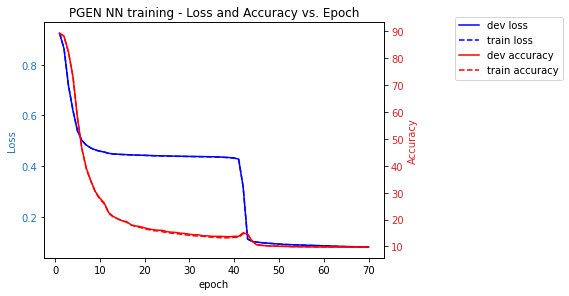

In [9]:
epochs = np.arange(1, args['epochs'] + 1)
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('epoch')
ax1.set_ylabel('Loss', color = color)
ax1.plot(epochs, dev_losses, 'b-', label = 'dev loss')
ax1.plot(epochs, train_losses, 'b--', label = 'train loss')
ax1.tick_params(axis='y', labelcolor = color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Accuracy', color = color)  # we already handled the x-label with ax1
ax2.plot(epochs, dev_accuracy, 'r-', label='dev accuracy')
ax2.plot(epochs, train_accuracy, 'r--', label='train accuracy')
ax2.tick_params(axis='y', labelcolor = color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('PGEN NN training - Loss and Accuracy vs. Epoch')
fig.savefig(FIG_PATH + 'PGEN NN training - Loss and Accuracy vs Epoch', bbox_inches='tight')
plt.show()

# # Models with different architecture

In [10]:
class PGEN_NN_PLS_CONV(nn.Module):
    def __init__(self):
        super(PGEN_NN_PLS_CONV, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.conv2 = nn.Conv2d(16, 32, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(4608, 1024)
        self.fc2 = nn.Linear(1024, 784)

    def forward(self, x):
        org = x
        x = self.conv1(x)  # 16,26,26
        x = F.relu(x)
        x = self.conv2(x)  # 32,24,24
        x = F.relu(x)
        x = F.max_pool2d(x, 2)  # 32,12,12
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = torch.reshape(x, (-1, 1, PIC_DIM, PIC_DIM))
        output = torch.clamp(torch.tanh(x) * EPS + org, 0, 1)
        return output, x

    def generate(self, x, device):
        org = x
        x = self.conv1(x)  # 16,26,26
        x = F.relu(x)
        x = self.conv2(x)  # 32,24,24
        x = F.relu(x)
        x = F.max_pool2d(x, 2)  # 16,13,13
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = torch.reshape(x, (-1, 1, PIC_DIM, PIC_DIM))
        x = torch.tanh(x).cpu().numpy()
        x = torch.from_numpy(np.where(np.abs(x) > THR, x, 0)).to(device)
        output = torch.clamp(torch.sign(x) * EPS + org, 0, 1)
        return output, x

In [11]:
class PGEN_NN_MNS_LIN(nn.Module):
    def __init__(self):
        super(PGEN_NN_MNS_LIN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(2704, 784)

    def forward(self, x):
        org = x
        x = self.conv1(x)  # 16,26,26
        x = F.relu(x)
        x = F.max_pool2d(x, 2)  # 16,13,13
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.reshape(x, (-1, 1, PIC_DIM, PIC_DIM))
        output = torch.clamp(torch.tanh(x) * EPS + org, 0, 1)
        return output, x

    def generate(self, x, device):
        org = x
        x = self.conv1(x)  # 16,26,26
        x = F.relu(x)
        x = F.max_pool2d(x, 2)  # 16,13,13
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = torch.reshape(x, (-1, 1, PIC_DIM, PIC_DIM))
        x = torch.tanh(x).cpu().numpy()
        x = torch.from_numpy(np.where(np.abs(x) > THR, x, 0)).to(device)
        output = torch.clamp(torch.sign(x) * EPS + org, 0, 1)
        return output, x

## Train PGEN_NN_PLS_CONV

In [12]:
# create model, initialize optimizer
args['model_name'] = 'pgen_nn_pls_conv'
model = PGEN_NN_PLS_CONV().to(device)
optimizer = optim.Adadelta(model.parameters())

dev_losses_pls_conv, train_losses_pls_conv, dev_accuracy_pls_conv, train_accuracy_pls_conv = main(
    args, model, optimizer, cnn, train_loader, dev_loader, device)

Train Epoch: 1 [0/50000 (0%)]	Loss: 197.197205
Train Epoch: 1 [6400/50000 (13%)]	Loss: 0.754696
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.778672
Train Epoch: 1 [19200/50000 (38%)]	Loss: 0.838131
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.809988
Train Epoch: 1 [32000/50000 (64%)]	Loss: 0.825608
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.875811
Train Epoch: 1 [44800/50000 (90%)]	Loss: 0.760938
Testing train set:

Testing set: Average loss: 0.7927, Accuracy: 42626/50000 (85%), noise average = 783.5037

Testing dev set:

Testing set: Average loss: 0.7903, Accuracy: 8504/10000 (85%), noise average = 783.5051

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.708455
Train Epoch: 2 [6400/50000 (13%)]	Loss: 0.741467
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.760423
Train Epoch: 2 [19200/50000 (38%)]	Loss: 0.792198
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.707862
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.783908
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.819975
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.

Train Epoch: 14 [32000/50000 (64%)]	Loss: 0.515172
Train Epoch: 14 [38400/50000 (77%)]	Loss: 0.544354
Train Epoch: 14 [44800/50000 (90%)]	Loss: 0.525504
Testing train set:

Testing set: Average loss: 0.5103, Accuracy: 25273/50000 (51%), noise average = 777.9952

Testing dev set:

Testing set: Average loss: 0.5099, Accuracy: 5116/10000 (51%), noise average = 777.9498

Train Epoch: 15 [0/50000 (0%)]	Loss: 0.544006
Train Epoch: 15 [6400/50000 (13%)]	Loss: 0.550950
Train Epoch: 15 [12800/50000 (26%)]	Loss: 0.509746
Train Epoch: 15 [19200/50000 (38%)]	Loss: 0.506024
Train Epoch: 15 [25600/50000 (51%)]	Loss: 0.483606
Train Epoch: 15 [32000/50000 (64%)]	Loss: 0.489001
Train Epoch: 15 [38400/50000 (77%)]	Loss: 0.489390
Train Epoch: 15 [44800/50000 (90%)]	Loss: 0.484112
Testing train set:

Testing set: Average loss: 0.4803, Accuracy: 19800/50000 (40%), noise average = 776.2217

Testing dev set:

Testing set: Average loss: 0.4802, Accuracy: 3974/10000 (40%), noise average = 776.1683

Train Epoch

Testing train set:

Testing set: Average loss: 0.4371, Accuracy: 6842/50000 (14%), noise average = 769.3943

Testing dev set:

Testing set: Average loss: 0.4376, Accuracy: 1392/10000 (14%), noise average = 769.2623

Train Epoch: 28 [0/50000 (0%)]	Loss: 0.432349
Train Epoch: 28 [6400/50000 (13%)]	Loss: 0.444151
Train Epoch: 28 [12800/50000 (26%)]	Loss: 0.443821
Train Epoch: 28 [19200/50000 (38%)]	Loss: 0.443779
Train Epoch: 28 [25600/50000 (51%)]	Loss: 0.434734
Train Epoch: 28 [32000/50000 (64%)]	Loss: 0.441770
Train Epoch: 28 [38400/50000 (77%)]	Loss: 0.435112
Train Epoch: 28 [44800/50000 (90%)]	Loss: 0.440306
Testing train set:

Testing set: Average loss: 0.4365, Accuracy: 6670/50000 (13%), noise average = 768.9816

Testing dev set:

Testing set: Average loss: 0.4370, Accuracy: 1368/10000 (14%), noise average = 768.8590

Train Epoch: 29 [0/50000 (0%)]	Loss: 0.445496
Train Epoch: 29 [6400/50000 (13%)]	Loss: 0.449163
Train Epoch: 29 [12800/50000 (26%)]	Loss: 0.437950
Train Epoch: 29 [19

Train Epoch: 41 [0/50000 (0%)]	Loss: 0.074094
Train Epoch: 41 [6400/50000 (13%)]	Loss: 0.079513
Train Epoch: 41 [12800/50000 (26%)]	Loss: 0.079166
Train Epoch: 41 [19200/50000 (38%)]	Loss: 0.086102
Train Epoch: 41 [25600/50000 (51%)]	Loss: 0.071437
Train Epoch: 41 [32000/50000 (64%)]	Loss: 0.079372
Train Epoch: 41 [38400/50000 (77%)]	Loss: 0.082334
Train Epoch: 41 [44800/50000 (90%)]	Loss: 0.081160
Testing train set:

Testing set: Average loss: 0.0804, Accuracy: 4897/50000 (10%), noise average = 771.1209

Testing dev set:

Testing set: Average loss: 0.0804, Accuracy: 973/10000 (10%), noise average = 771.0652

Train Epoch: 42 [0/50000 (0%)]	Loss: 0.083264
Train Epoch: 42 [6400/50000 (13%)]	Loss: 0.095202
Train Epoch: 42 [12800/50000 (26%)]	Loss: 0.080165
Train Epoch: 42 [19200/50000 (38%)]	Loss: 0.084598
Train Epoch: 42 [25600/50000 (51%)]	Loss: 0.078140
Train Epoch: 42 [32000/50000 (64%)]	Loss: 0.086906
Train Epoch: 42 [38400/50000 (77%)]	Loss: 0.084612
Train Epoch: 42 [44800/50000 (90

Train Epoch: 54 [25600/50000 (51%)]	Loss: 0.075692
Train Epoch: 54 [32000/50000 (64%)]	Loss: 0.072157
Train Epoch: 54 [38400/50000 (77%)]	Loss: 0.083963
Train Epoch: 54 [44800/50000 (90%)]	Loss: 0.069303
Testing train set:

Testing set: Average loss: 0.0744, Accuracy: 4888/50000 (10%), noise average = 770.4502

Testing dev set:

Testing set: Average loss: 0.0746, Accuracy: 969/10000 (10%), noise average = 770.3254

Train Epoch: 55 [0/50000 (0%)]	Loss: 0.085215
Train Epoch: 55 [6400/50000 (13%)]	Loss: 0.077617
Train Epoch: 55 [12800/50000 (26%)]	Loss: 0.073612
Train Epoch: 55 [19200/50000 (38%)]	Loss: 0.076314
Train Epoch: 55 [25600/50000 (51%)]	Loss: 0.073155
Train Epoch: 55 [32000/50000 (64%)]	Loss: 0.071964
Train Epoch: 55 [38400/50000 (77%)]	Loss: 0.076412
Train Epoch: 55 [44800/50000 (90%)]	Loss: 0.073756
Testing train set:

Testing set: Average loss: 0.0742, Accuracy: 4891/50000 (10%), noise average = 770.2666

Testing dev set:

Testing set: Average loss: 0.0744, Accuracy: 969/100

Testing train set:

Testing set: Average loss: 0.0721, Accuracy: 4884/50000 (10%), noise average = 769.9384

Testing dev set:

Testing set: Average loss: 0.0724, Accuracy: 969/10000 (10%), noise average = 769.7113

Train Epoch: 68 [0/50000 (0%)]	Loss: 0.086306
Train Epoch: 68 [6400/50000 (13%)]	Loss: 0.082784
Train Epoch: 68 [12800/50000 (26%)]	Loss: 0.089227
Train Epoch: 68 [19200/50000 (38%)]	Loss: 0.071598
Train Epoch: 68 [25600/50000 (51%)]	Loss: 0.072646
Train Epoch: 68 [32000/50000 (64%)]	Loss: 0.088161
Train Epoch: 68 [38400/50000 (77%)]	Loss: 0.075659
Train Epoch: 68 [44800/50000 (90%)]	Loss: 0.066708
Testing train set:

Testing set: Average loss: 0.0720, Accuracy: 4887/50000 (10%), noise average = 769.7562

Testing dev set:

Testing set: Average loss: 0.0722, Accuracy: 969/10000 (10%), noise average = 769.5258

Train Epoch: 69 [0/50000 (0%)]	Loss: 0.072852
Train Epoch: 69 [6400/50000 (13%)]	Loss: 0.074287
Train Epoch: 69 [12800/50000 (26%)]	Loss: 0.077841
Train Epoch: 69 [1920

In [13]:
print('Testing test set:')
_ = test(model, device, test_loader, cnn)

Testing test set:

Testing set: Average loss: 0.0719, Accuracy: 974/10000 (10%), noise average = 769.5109



(tensor(0.0719, device='cuda:0'), 9.74)

## Train PGEN_NN_MNS_LIN

In [14]:
# create model, initialize optimizer
args['model_name'] = 'pgen_nn_mns_lin'
model = PGEN_NN_MNS_LIN().to(device)
optimizer = optim.Adadelta(model.parameters())

dev_losses_mns_lin, train_losses_mns_lin, dev_accuracy_mns_lin, train_accuracy_mns_lin = main(
    args, model, optimizer, cnn, train_loader, dev_loader, device)

Train Epoch: 1 [0/50000 (0%)]	Loss: 65.353073
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.196223
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.971984
Train Epoch: 1 [19200/50000 (38%)]	Loss: 0.887712
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.963894
Train Epoch: 1 [32000/50000 (64%)]	Loss: 0.817526
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.773878
Train Epoch: 1 [44800/50000 (90%)]	Loss: 0.882023
Testing train set:

Testing set: Average loss: 0.7776, Accuracy: 41686/50000 (83%), noise average = 765.6198

Testing dev set:

Testing set: Average loss: 0.7764, Accuracy: 8352/10000 (84%), noise average = 765.5106

Train Epoch: 2 [0/50000 (0%)]	Loss: 0.745401
Train Epoch: 2 [6400/50000 (13%)]	Loss: 0.809544
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.738852
Train Epoch: 2 [19200/50000 (38%)]	Loss: 0.788098
Train Epoch: 2 [25600/50000 (51%)]	Loss: 0.773905
Train Epoch: 2 [32000/50000 (64%)]	Loss: 0.701196
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.680854
Train Epoch: 2 [44800/50000 (90%)]	Loss: 0.6

Train Epoch: 14 [32000/50000 (64%)]	Loss: 0.540848
Train Epoch: 14 [38400/50000 (77%)]	Loss: 0.522627
Train Epoch: 14 [44800/50000 (90%)]	Loss: 0.536317
Testing train set:

Testing set: Average loss: 0.5278, Accuracy: 25565/50000 (51%), noise average = 751.1714

Testing dev set:

Testing set: Average loss: 0.5280, Accuracy: 5160/10000 (52%), noise average = 750.9770

Train Epoch: 15 [0/50000 (0%)]	Loss: 0.544853
Train Epoch: 15 [6400/50000 (13%)]	Loss: 0.543562
Train Epoch: 15 [12800/50000 (26%)]	Loss: 0.522446
Train Epoch: 15 [19200/50000 (38%)]	Loss: 0.549812
Train Epoch: 15 [25600/50000 (51%)]	Loss: 0.556191
Train Epoch: 15 [32000/50000 (64%)]	Loss: 0.550341
Train Epoch: 15 [38400/50000 (77%)]	Loss: 0.540059
Train Epoch: 15 [44800/50000 (90%)]	Loss: 0.515925
Testing train set:

Testing set: Average loss: 0.5242, Accuracy: 24779/50000 (50%), noise average = 749.8975

Testing dev set:

Testing set: Average loss: 0.5245, Accuracy: 5021/10000 (50%), noise average = 749.7038

Train Epoch

Testing train set:

Testing set: Average loss: 0.4840, Accuracy: 18240/50000 (36%), noise average = 746.3046

Testing dev set:

Testing set: Average loss: 0.4847, Accuracy: 3717/10000 (37%), noise average = 745.9966

Train Epoch: 28 [0/50000 (0%)]	Loss: 0.491264
Train Epoch: 28 [6400/50000 (13%)]	Loss: 0.499165
Train Epoch: 28 [12800/50000 (26%)]	Loss: 0.482278
Train Epoch: 28 [19200/50000 (38%)]	Loss: 0.480889
Train Epoch: 28 [25600/50000 (51%)]	Loss: 0.499588
Train Epoch: 28 [32000/50000 (64%)]	Loss: 0.503543
Train Epoch: 28 [38400/50000 (77%)]	Loss: 0.479887
Train Epoch: 28 [44800/50000 (90%)]	Loss: 0.482042
Testing train set:

Testing set: Average loss: 0.4828, Accuracy: 18012/50000 (36%), noise average = 746.2427

Testing dev set:

Testing set: Average loss: 0.4836, Accuracy: 3681/10000 (37%), noise average = 745.9322

Train Epoch: 29 [0/50000 (0%)]	Loss: 0.484698
Train Epoch: 29 [6400/50000 (13%)]	Loss: 0.488719
Train Epoch: 29 [12800/50000 (26%)]	Loss: 0.488841
Train Epoch: 29 [

Train Epoch: 41 [0/50000 (0%)]	Loss: 0.466043
Train Epoch: 41 [6400/50000 (13%)]	Loss: 0.485594
Train Epoch: 41 [12800/50000 (26%)]	Loss: 0.488894
Train Epoch: 41 [19200/50000 (38%)]	Loss: 0.469648
Train Epoch: 41 [25600/50000 (51%)]	Loss: 0.455104
Train Epoch: 41 [32000/50000 (64%)]	Loss: 0.464337
Train Epoch: 41 [38400/50000 (77%)]	Loss: 0.479418
Train Epoch: 41 [44800/50000 (90%)]	Loss: 0.458891
Testing train set:

Testing set: Average loss: 0.4656, Accuracy: 14740/50000 (29%), noise average = 744.3550

Testing dev set:

Testing set: Average loss: 0.4664, Accuracy: 2985/10000 (30%), noise average = 744.0379

Train Epoch: 42 [0/50000 (0%)]	Loss: 0.456349
Train Epoch: 42 [6400/50000 (13%)]	Loss: 0.462593
Train Epoch: 42 [12800/50000 (26%)]	Loss: 0.461480
Train Epoch: 42 [19200/50000 (38%)]	Loss: 0.453044
Train Epoch: 42 [25600/50000 (51%)]	Loss: 0.468631
Train Epoch: 42 [32000/50000 (64%)]	Loss: 0.467025
Train Epoch: 42 [38400/50000 (77%)]	Loss: 0.464662
Train Epoch: 42 [44800/50000 (

Train Epoch: 54 [19200/50000 (38%)]	Loss: 0.456750
Train Epoch: 54 [25600/50000 (51%)]	Loss: 0.464105
Train Epoch: 54 [32000/50000 (64%)]	Loss: 0.462862
Train Epoch: 54 [38400/50000 (77%)]	Loss: 0.457453
Train Epoch: 54 [44800/50000 (90%)]	Loss: 0.449074
Testing train set:

Testing set: Average loss: 0.4568, Accuracy: 12854/50000 (26%), noise average = 742.4432

Testing dev set:

Testing set: Average loss: 0.4577, Accuracy: 2628/10000 (26%), noise average = 742.0676

Train Epoch: 55 [0/50000 (0%)]	Loss: 0.447818
Train Epoch: 55 [6400/50000 (13%)]	Loss: 0.463889
Train Epoch: 55 [12800/50000 (26%)]	Loss: 0.461297
Train Epoch: 55 [19200/50000 (38%)]	Loss: 0.458736
Train Epoch: 55 [25600/50000 (51%)]	Loss: 0.456819
Train Epoch: 55 [32000/50000 (64%)]	Loss: 0.457489
Train Epoch: 55 [38400/50000 (77%)]	Loss: 0.452721
Train Epoch: 55 [44800/50000 (90%)]	Loss: 0.469722
Testing train set:

Testing set: Average loss: 0.4563, Accuracy: 12738/50000 (25%), noise average = 742.1963

Testing dev set:

Train Epoch: 67 [38400/50000 (77%)]	Loss: 0.456093
Train Epoch: 67 [44800/50000 (90%)]	Loss: 0.452409
Testing train set:

Testing set: Average loss: 0.4527, Accuracy: 11765/50000 (24%), noise average = 741.5869

Testing dev set:

Testing set: Average loss: 0.4537, Accuracy: 2435/10000 (24%), noise average = 741.2188

Train Epoch: 68 [0/50000 (0%)]	Loss: 0.446553
Train Epoch: 68 [6400/50000 (13%)]	Loss: 0.456617
Train Epoch: 68 [12800/50000 (26%)]	Loss: 0.454248
Train Epoch: 68 [19200/50000 (38%)]	Loss: 0.455137
Train Epoch: 68 [25600/50000 (51%)]	Loss: 0.451458
Train Epoch: 68 [32000/50000 (64%)]	Loss: 0.452595
Train Epoch: 68 [38400/50000 (77%)]	Loss: 0.457938
Train Epoch: 68 [44800/50000 (90%)]	Loss: 0.457388
Testing train set:

Testing set: Average loss: 0.4526, Accuracy: 11751/50000 (24%), noise average = 741.8254

Testing dev set:

Testing set: Average loss: 0.4536, Accuracy: 2425/10000 (24%), noise average = 741.4805

Train Epoch: 69 [0/50000 (0%)]	Loss: 0.459914
Train Epoch: 69 

In [15]:
print('Testing test set:')
_ = test(model, device, test_loader, cnn)

Testing test set:

Testing set: Average loss: 0.4530, Accuracy: 2369/10000 (24%), noise average = 741.3527



(tensor(0.4530, device='cuda:0'), 23.69)

## Plot comperative graphs

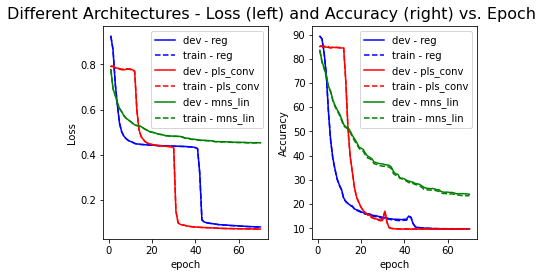

In [23]:
epochs = np.arange(1, args['epochs'] + 1)
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.set_xlabel('epoch')
ax1.set_ylabel('Loss')
ax1.plot(epochs, dev_losses, 'b-', label = 'dev - reg')
ax1.plot(epochs, train_losses, 'b--', label = 'train - reg')
ax1.plot(epochs, dev_losses_pls_conv, 'r-', label = 'dev - pls_conv')
ax1.plot(epochs, train_losses_pls_conv, 'r--', label = 'train - pls_conv')
ax1.plot(epochs, dev_losses_mns_lin, 'g-', label = 'dev - mns_lin')
ax1.plot(epochs, train_losses_mns_lin, 'g--', label = 'train - mns_lin')
ax1.tick_params(axis='y')

ax2.set_xlabel('epoch')
ax2.set_ylabel('Accuracy') 
ax2.plot(epochs, dev_accuracy, 'b-', label = 'dev - reg')
ax2.plot(epochs, train_accuracy, 'b--', label = 'train - reg')
ax2.plot(epochs, dev_accuracy_pls_conv, 'r-', label = 'dev - pls_conv')
ax2.plot(epochs, train_accuracy_pls_conv, 'r--', label = 'train - pls_conv')
ax2.plot(epochs, dev_accuracy_mns_lin, 'g-', label = 'dev - mns_lin')
ax2.plot(epochs, train_accuracy_mns_lin, 'g--', label = 'train - mns_lin')
ax2.tick_params(axis='y')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # otherwise the right y-label is slightly clipped
ax1.legend()
ax2.legend()
fig.suptitle('Different Architectures - Loss (left) and Accuracy (right) vs. Epoch', fontsize=16)
fig.savefig(FIG_PATH + 'Different Architectures - Loss and Accuracy vs Epoch', bbox_inches='tight')
plt.show()